Lingjie is working on a dataset of 1817 NCLDV genomes, and so I decided to have a look at the
ANI distribution of these genomes and compare it to the tree he's built.

I ran `fastANI` with a fragment length of 3000 and $k$-mer length of 16, and `CheckV` v1.0.1 with
the default database and parameters

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import pandas
import seaborn
import gzip
from Bio import SeqIO
import pyprind
from SuchTree import SuchTree
from Bio.SeqIO import parse
from Bio.SeqUtils import GC
from io import BufferedReader, TextIOWrapper
import tarfile
from os import path

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# dataset properties

fraglength = 3000  # fastANI fragment length 
kmer       = 16    # fastANI k-mer length
min_aln    = 10    # minimum number of aligned fragments
max_ani    = 100 # maximum ANI threshold

In [3]:
header = ['query', 'reference', 'ANI', 'bidirectional fragment mappings', 'total query fragments' ]
fastani = pandas.read_csv( 'data/lingjie/lingjie_ncldvs_vs_ncldvs_fastani.txt', sep='\t', names=header )

# drop self-hits
fastani = fastani[ fastani['query'] != fastani['reference'] ]

# de-duplicate (i.e., take the lower triangle of the matrix)
fastani['hash'] = fastani.apply( lambda row : hash( tuple( sorted( ( row['query'], row['reference'] ) ) ) ), axis=1 )
fastani.drop_duplicates( subset='hash', keep='first', inplace=True )
fastani.drop( ['hash'], axis=1, inplace=True )

fastani['query']     = [ q[15:-3] for q in fastani['query'] ]
fastani['reference'] = [ r[15:-3] for r in fastani['reference'] ]

def tarball_fasta_summary( tarball ) :
    '''
    Summarize the FASTA files in a tarball.
    '''
    tb = tarfile.open( tarball, 'r' )
    data = {}
    for name in tb.getnames() :
        f = tb.extractfile( name )
        if name.endswith( '.fa' ) :
            taxon = path.split( name )[-1][:-3]
            data[taxon] = { 'contigs' : 0, 'size' : 0, 'G+C' : 0 }
            sizes = []
            gcs   = []
            for n,rec in enumerate( SeqIO.parse( TextIOWrapper(f), 'fasta' ) ) :
                sizes.append( len(rec) )
                gcs.append(   GC(rec.seq)  )
            data[taxon]['contigs']      = len(sizes)
            data[taxon]['size']         = sum(sizes)
            data[taxon]['G+C']          = mean(gcs)
    return data

# add sequence statistic ANI table
seqsummary = tarball_fasta_summary( 'data/lingjie/lingjie_ncldvs.tar.gz' )

fastani['query_contigs'] = [ seqsummary[x]['contigs'] for x in fastani['query'] ]
fastani['query_size']    = [ seqsummary[x]['size'] for x in fastani['query'] ]
fastani['query_G+C']     = [ seqsummary[x]['G+C'] for x in fastani['query'] ]

fastani['reference_contigs'] = [ seqsummary[x]['contigs'] for x in fastani['reference'] ]
fastani['reference_size']    = [ seqsummary[x]['size'] for x in fastani['reference'] ]
fastani['reference_G+C']     = [ seqsummary[x]['G+C'] for x in fastani['reference'] ]

fastani['size_deviation'] = [ abs( row['query_size'] - row['reference_size'] )
                               / ( row['query_size'] + row['reference_size'] ) for n,row in fastani.iterrows() ]

fastani['G+C_deviation']  = [ abs( row['query_G+C'] - row['reference_G+C'] ) for n,row in fastani.iterrows() ]

# compute phylogenetic distances between each ANI pair
T = SuchTree( 'data/lingjie/Mixture.Conca4.2ndRound.treefile' )

fastani['treedist'] = fastani[ ( fastani['query'].isin( T.leafs ) ) 
                             & ( fastani['reference'].isin( T.leafs ) ) ].apply(
                                    lambda row : T.distance( row['query'], row['reference'] ), axis=1 )

# merge metadata
md_cols = [ 'Final_names',
            'Source',
            'Status',
            'Realm',
            'Phylum',
            'Class',
            'Order',
            'Family_Linking_to_GVDB',
            'Family_manual',
            'Subfamily_manual',
            'Genus_manual',
            'N50' ]

raw_metadata = pandas.read_csv( 'data/lingjie/general_metadata.csv' )
metadata = raw_metadata[ md_cols ]

fastani = pandas.merge( fastani, metadata, how='left', left_on='query', right_on='Final_names' )
fastani.rename( columns={ c : 'query_' + c.lower() for c in md_cols }, inplace=True )

fastani = pandas.merge( fastani, metadata, how='left', left_on='reference', right_on='Final_names' )
fastani.rename( columns={ c : 'reference_' + c.lower() for c in md_cols }, inplace=True )

# merge CheckV results
checkv = pandas.read_csv( 'data/lingjie/checkv_putput/quality_summary.tsv', sep='\t' )

fastani = pandas.merge( fastani, checkv, how='left', left_on='query', right_on='contig_id' )
fastani.rename( columns={ c : 'query_' + c for c in checkv.columns }, inplace=True )

fastani = pandas.merge( fastani, checkv, how='left', left_on='reference', right_on='contig_id' )
fastani.rename( columns={ c : 'reference_' + c for c in checkv.columns }, inplace=True )

fastani

,query,reference,ANI,bidirectional fragment mappings,total query fragments,query_contigs,query_size,query_G+C,reference_contigs,reference_size,...,reference_gene_count,reference_viral_genes,reference_host_genes,reference_checkv_quality,reference_miuvig_quality,reference_completeness,reference_completeness_method,reference_contamination,reference_kmer_freq,reference_warnings
0,Ascoviridae_EF133465_Heliothis_virescens_ascov...,Ascoviridae_KJ755191_Heliothis_virescens_ascov...,92.6268,59,62,1,186262,45.874628,1,198157,...,190,84,1,High-quality,High-quality,99.64,AAI-based (high-confidence),0.0,1.01,NaN
1,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_AY261362_African_swine_fever_viru...,98.3171,57,57,1,171719,38.865239,1,192714,...,173,76,1,Complete,High-quality,100.00,ITR (high-confidence),0.0,1.02,NaN
2,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_MG939588_UNVERIFIED_African_swine...,97.4336,57,57,1,171719,38.865239,1,189401,...,169,71,1,High-quality,High-quality,99.03,AAI-based (high-confidence),0.0,1.01,NaN
3,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_AY261365_African_swine_fever_viru...,96.9407,56,57,1,171719,38.865239,1,190773,...,173,76,0,Complete,High-quality,100.00,ITR (high-confidence),0.0,1.01,NaN
4,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_AY261366_African_swine_fever_viru...,96.6890,53,57,1,171719,38.865239,1,186528,...,170,72,0,Complete,High-quality,100.00,ITR (high-confidence),0.0,1.01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17735,mPacV_611,Moniruzzaman_AF05_ERX552270_16_dc,74.8696,20,200,7,610889,25.479888,10,262392,...,226,31,4,Medium-quality,Genome-fragment,52.49,HMM-based (lower-bound),0.0,1.01,NaN
17736,mPacV_611,TARA_ARC_NCLDV_00083,74.8567,15,200,7,610889,25.479888,27,225268,...,259,75,8,Low-quality,Genome-fragment,48.25,AAI-based (medium-confidence),0.0,1.02,NaN
17737,mPacV_611,TARA_AON_NCLDV_00043,74.6936,8,200,7,610889,25.479888,34,165524,...,166,25,5,Low-quality,Genome-fragment,35.55,AAI-based (medium-confidence),0.0,1.02,NaN
17738,mPacV_611,TARA_PSW_NCLDV_00065,74.6394,10,200,7,610889,25.479888,3,142957,...,130,30,7,Low-quality,Genome-fragment,13.94,AAI-based (medium-confidence),0.0,1.01,NaN


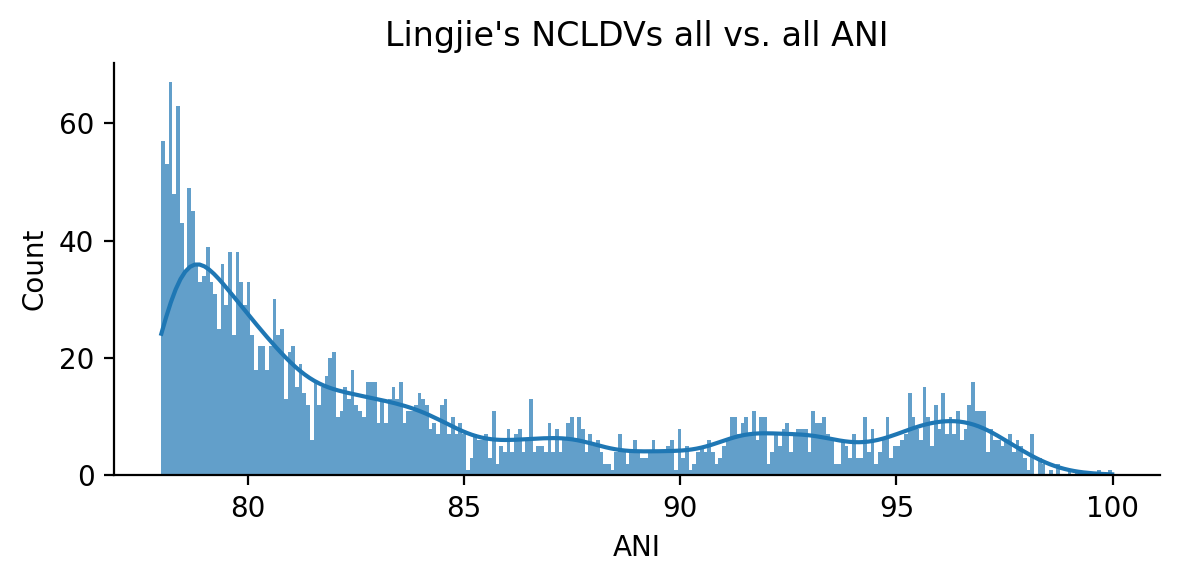

In [4]:
g = seaborn.displot( data=fastani[ ( fastani.ANI < max_ani )
                                 & ( fastani.ANI > 78 )
                                 & ( fastani['bidirectional fragment mappings'] > 5 ) ],
                         x='ANI', kind='hist', kde=True, kde_kws={'bw_method':0.1}, bins=256,
                         fill=True, common_norm=False, palette='viridis', 
                         alpha=.7, linewidth=0, height=3, aspect=2)

title( 'Lingjie\'s NCLDVs all vs. all ANI' )
tight_layout()
savefig( 'figures/lingjie_ncldvs_ANI_distribution.png', facecolor='white', dpi=200 )

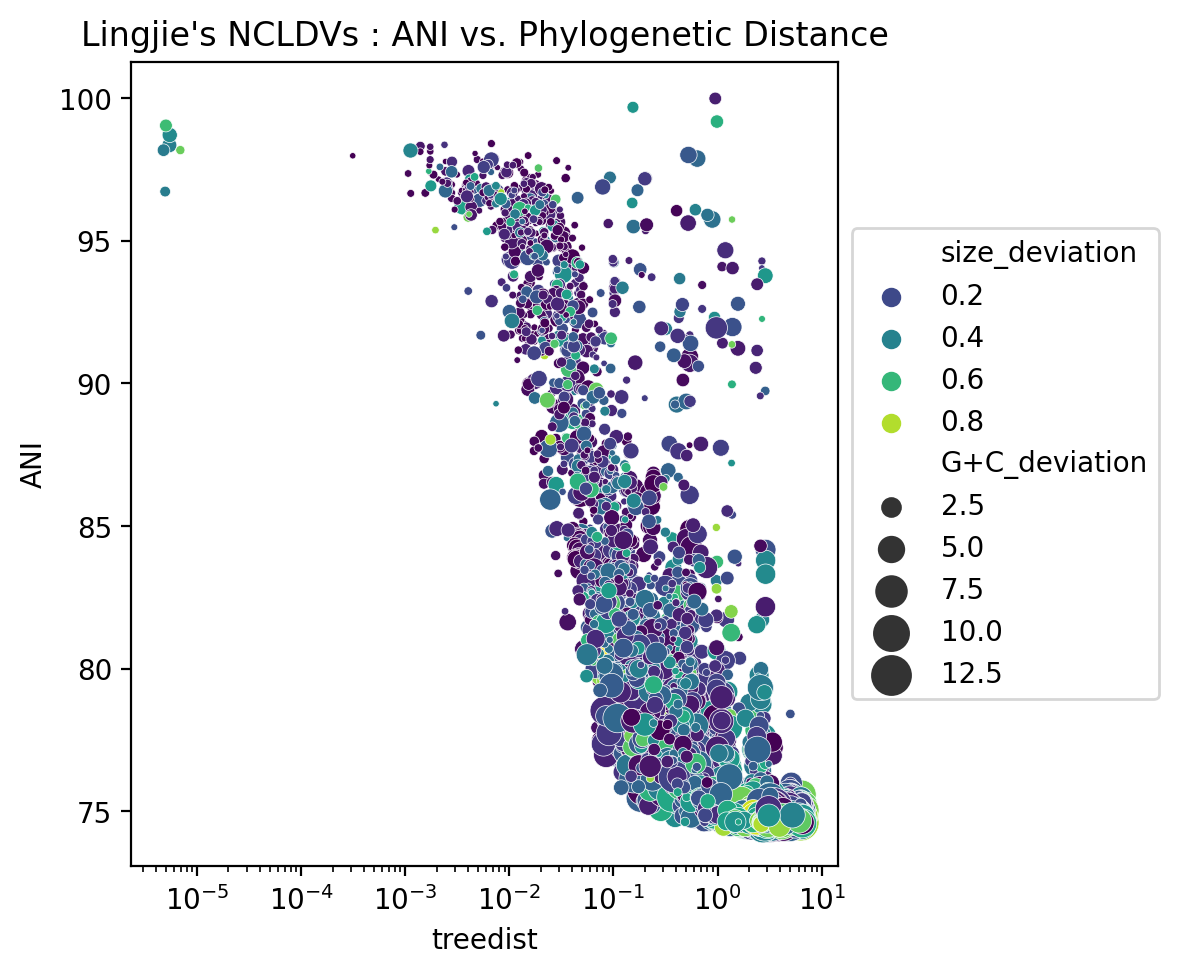

In [9]:
figure( figsize=(6,5) )

g = seaborn.scatterplot( data=fastani[ ( fastani['ANI'] < max_ani )
                                 & ( fastani['ANI'] > 70 )
                                 #& ( fastani['treedist'] > 0.2 )
                                 & ( fastani['bidirectional fragment mappings'] > 10 ) ],
                         y='ANI', x='treedist', hue='size_deviation', size='G+C_deviation',
                         sizes=( 5, 200 ),
                         palette='viridis' )

g.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

semilogx()
title( 'Lingjie\'s NCLDVs : ANI vs. Phylogenetic Distance' )

tight_layout()
savefig( 'figures/lingjie_ncldvs_ANI_vs_treedist.png', facecolor='white', dpi=200 )

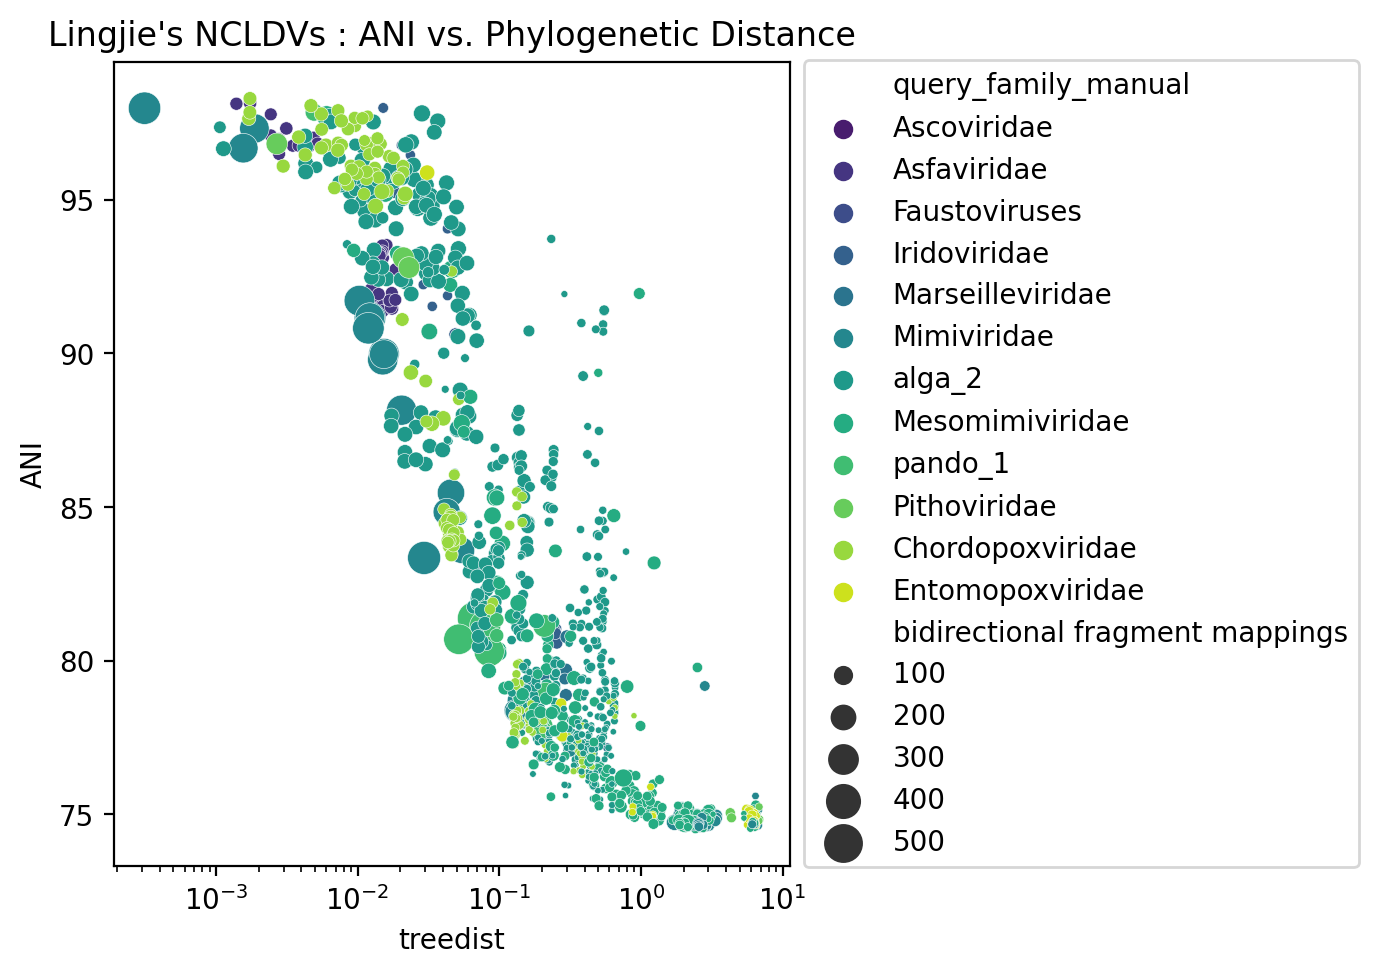

In [6]:
figure( figsize=(7,5) )

g = seaborn.scatterplot( data=fastani[ ( fastani['ANI'] < max_ani )
                                 & ( fastani['ANI'] > 70 )
                                 #& ( fastani['treedist'] > 0.2 )
                                 & ( fastani['bidirectional fragment mappings'] > 1 )
                                 & ( fastani['query_checkv_quality'].isin( [ 'High-quality', 'Complete' ] ) )
                                 & ( fastani['reference_checkv_quality'].isin( [ 'High-quality', 'Complete' ] ) ) ],
                         y='ANI', x='treedist', hue='query_family_manual', size='bidirectional fragment mappings',
                         sizes=( 5, 200 ),
                         palette='viridis' )

g.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

semilogx()
title( 'Lingjie\'s NCLDVs : ANI vs. Phylogenetic Distance' )

tight_layout()
savefig( 'figures/lingjie_ncldvs_ANI_vs_treedist_checkv.png', facecolor='white', dpi=200 )

In [7]:
anomaly = fastani[ ( fastani['ANI'] < max_ani )
                 & ( fastani['ANI'] > 88 )
                 & ( fastani['treedist'] > 0.2 )
                 & ( fastani['bidirectional fragment mappings'] > 1 ) ]

anomaly[ anomaly['treedist'] > 2.0 ][ ['query', 'reference', 'ANI', 
                                       'bidirectional fragment mappings',
                                       'query_checkv_quality',
                                       'reference_checkv_quality'] ]

,query,reference,ANI,bidirectional fragment mappings,query_checkv_quality,reference_checkv_quality
2736,Moniruzzaman_MM01_ERX552270_62_dc,Moniruzzaman_MM12_ERX555958_4_dc,94.2909,93,High-quality,Medium-quality
2737,Moniruzzaman_MM01_ERX552270_62_dc,TARA_AON_NCLDV_00003,94.0431,84,High-quality,Medium-quality
2738,Moniruzzaman_MM01_ERX552270_62_dc,TARA_ARC_NCLDV_00124,92.2616,24,High-quality,Low-quality
3354,Moniruzzaman_MM01_ERX552302_42_dc,Schulz_GVMAG_S_3300000115_70,91.1558,26,Medium-quality,Medium-quality
3564,Moniruzzaman_MM01_ERX556037_25_dc,TARA_AON_NCLDV_00039,93.7771,16,High-quality,Low-quality
3565,Moniruzzaman_MM01_ERX556037_25_dc,Schulz_GVMAG_M_3300023109_20,89.7376,33,High-quality,Low-quality
3816,Moniruzzaman_MM01_SRX803008_24_dc,Schulz_GVMAG_S_3300000115_70,93.4764,29,Medium-quality,Medium-quality
8908,Schulz_GVMAG_M_3300009076_8,TARA_ARC_NCLDV_00184,93.2359,4,High-quality,Low-quality
9036,Schulz_GVMAG_M_3300009498_22,Schulz_GVMAG_S_1074258_71,90.5492,12,Medium-quality,Low-quality
10254,Schulz_GVMAG_M_3300020182_10,Schulz_GVMAG_M_3300020187_12,89.5639,35,Medium-quality,Medium-quality


Text(0.5, 1.0, "Lingjie's NCLDVs : ANI vs. Phylogenetic Distance")

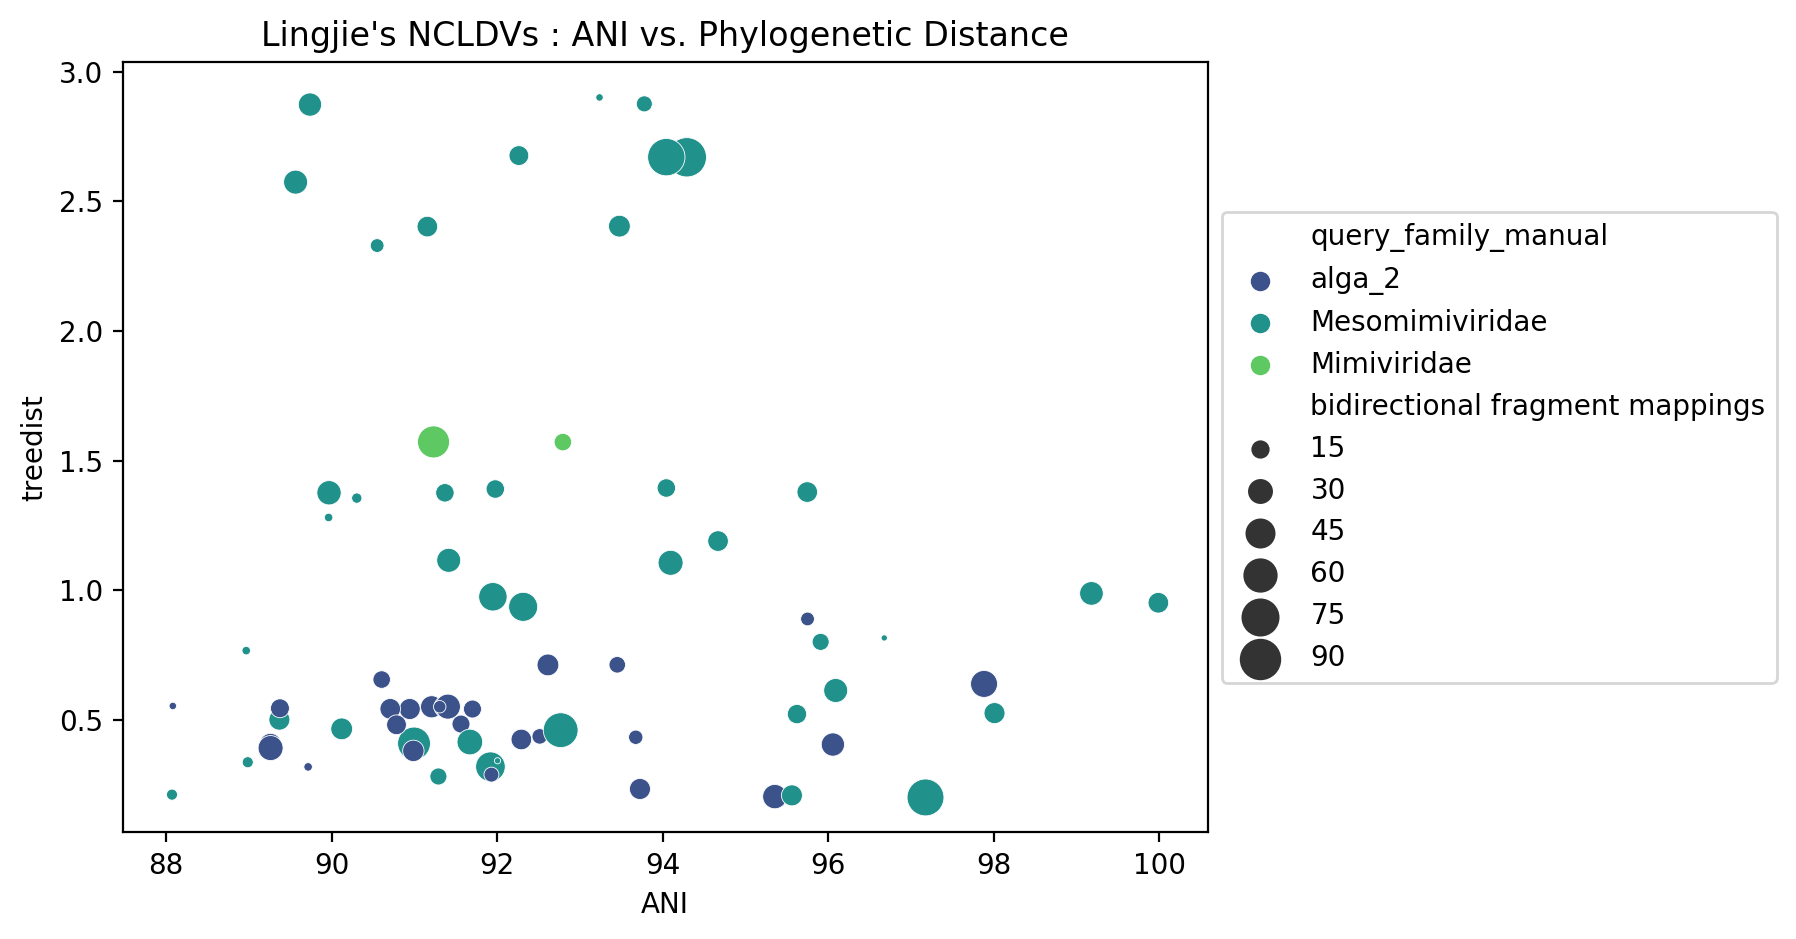

In [8]:
figure( figsize=(7,5) )

g = seaborn.scatterplot( data=anomaly,
                         x='ANI', y='treedist',
                         hue='query_family_manual', size='bidirectional fragment mappings',
                         sizes=( 5, 200 ),
                         palette='viridis' )

g.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

#axvspan( 89, 100, 0.5, 0.95, alpha=0.1 )

title( 'Lingjie\'s NCLDVs : ANI vs. Phylogenetic Distance' )

In [37]:
import csv
import numpy as np
from pathlib import Path

from Bio import SeqIO
from pygenomeviz import GenomeViz
from pygenomeviz.utils import ColorCycler



# Resource files for visualization

genome_fatat_file0 = Path( 'data/lingjie/anomaly/TARA_AON_NCLDV_00003.fa' )
fastani_visual_file10 = Path( 'data/lingjie/anomaly/2737.out.visual' )
genome_fasta_file1 = Path( 'data/lingjie/anomaly/Moniruzzaman_MM01_ERX552270_62_dc.fa' )
fastani_visual_file12 = Path( 'data/lingjie/anomaly/2736.out.visual' )
genome_fasta_file2 = Path( 'data/lingjie/anomaly/Moniruzzaman_MM12_ERX555958_4_dc.fa' )

COLORMAP = 'viridis'
LINK_COLOR = 'black'
CURVE = True

# Load genome fasta information
genome_name0 = genome_fasta_file0.with_suffix("").name
genome_name1 = genome_fasta_file1.with_suffix("").name
genome_name2 = genome_fasta_file2.with_suffix("").name
records0 = SeqIO.parse(genome_fasta_file0, "fasta")
contigs0 = [len(r) for r in records0]
seq_length0 = sum(contigs0)
records1 = SeqIO.parse(genome_fasta_file1, "fasta")
contigs1 = [len(r) for r in records1]
seq_length1 = sum(contigs1)
records2 = SeqIO.parse(genome_fasta_file2, "fasta")
contigs2 = [len(r) for r in records2]
seq_length2 = sum(contigs2)

# Load fastANI visual result
#for fastani_results10 = []
with open(fastani_visual_file10) as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        start1, end1 = int(row[6]), int(row[7])
        start2, end2 = int(row[8]), int(row[9])
        identity = float(row[2])
        link1, link2 = (genome_name1, start1, end1), (genome_name2, start2, end2)
        fastani_results.append((link1, link2, identity))

# Visualize conserved regions detected by fastANI
gv = GenomeViz(
    fig_width=15,
    fig_track_height=1.0,
    feature_track_ratio=0.1,
    tick_track_ratio=0.2,
    align_type="center",  # "left", "center", "right"
    tick_style="bar",  # "axis", "bar", None
    plot_size_thr=0,
)

track1 = gv.add_feature_track(genome_name1, seq_length1)
track2 = gv.add_feature_track(genome_name2, seq_length2)

pos = 0
for i,color in zip( contigs1, ['#eeeeee', '#aaaaaa'] * len(contigs1) ) :
    track1.add_feature( pos, pos+i, 1, plotstyle='box', facecolor=color ) 
    pos = i+pos

pos = 0
for i,color in zip( contigs2, ['#eeeeee', '#aaaaaa'] * len(contigs2) ) :
    track2.add_feature( pos, pos+i, -1, plotstyle='box', facecolor=color ) 
    pos = i+pos

ColorCycler.set_cmap(COLORMAP)  # "hsv", "viridis", "jet", etc...
colormap, data_num = ColorCycler.cmap, len(fastani_results)
colors = [colormap(int(i)) for i in np.linspace(0, colormap.N, data_num)]

min_identity = int(min([res[2] for res in fastani_results]))
for res, color in zip(fastani_results, colors):
    link1, link2, identity = res
    track1.add_feature(link1[1], link1[2], -1, plotstyle="box", facecolor=color)
    track2.add_feature(link2[1], link2[2], 1, plotstyle="box", facecolor=color)
    gv.add_link(link1, link2, LINK_COLOR, v=identity, vmin=min_identity, curve=CURVE)

fig = gv.plotfig()

gv.set_colorbar(
    fig, bar_colors=[LINK_COLOR], vmin=min_identity, bar_height=0.3, bar_bottom=0.2
)

NameError: name 'genome_fasta_file0' is not defined

In [72]:
import tarfile
from functools import reduce

tb = tarfile.open( 'data/lingjie/lingjie_ncldvs.tar.gz', 'r' )
with open( 'data/lingjie/concatinated.fasta', 'w' ) as fout :
    for name in tb.getnames() :
        f = tb.extractfile( name )
        if name.endswith( '.fa' ) :
            taxon = path.split( name )[-1][:-3]
            concat = reduce( lambda a,b:a+b, [ rec for rec in SeqIO.parse( TextIOWrapper(f), 'fasta' ) ] )
            concat.id = taxon
            concat.description = ''
            fout.write( concat.format('fasta') )

In [108]:
fastani['within_genus'] = fastani.apply( lambda row : row['query_genus_manual'] == row['reference_genus_manual'], axis=1 )

In [130]:
checkv['checkv_quality'].value_counts()

Medium-quality    798
Low-quality       633
High-quality      324
Complete           61
Not-determined      1
Name: checkv_quality, dtype: int64

In [10]:
import toytree

droplist = list( checkv[ checkv['checkv_quality'].isin(['Low-quality',
                                                        'Medium-quality'
                                                        'Undetermined' ]) ]['contig_id'] )

tt = toytree.tree( 'data/lingjie/Mixture.Conca4.2ndRound.treefile' )
toytree.mod.drop_tips( tt, droplist, inplace=True )

⚠️ [toytree] toytree.mod._src.mod_topo: No tips selected. Matched query: []


In [40]:
toytree.mod.drop_tips( tt, [ node for node in tt.get_nodes() if node.name in droplist ], inplace=True )

#toytree.ToyTree.draw tt.draw( width=500, height=500, layout='u1', tip_labels=False )

⚠️ [toytree] toytree.mod._src.mod_topo: No tips selected. Matched query: []


In [48]:
header = ['query', 'reference', 'ANI', 'bidirectional fragment mappings', 'total query fragments' ]
simulated = pandas.read_csv( '/home/russell/pkg/Simulome/simulated_ecoli', sep='\t', names=header )

(array([ 6.,  4., 10., 14., 16., 11., 21., 13.,  6.,  5.,  1.,  1.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.]),
 array([ 85.5617    ,  85.67449922,  85.78729844,  85.90009766,
         86.01289687,  86.12569609,  86.23849531,  86.35129453,
         86.46409375,  86.57689297,  86.68969219,  86.80249141,
         86.91529062,  87.02808984,  87.14088906,  87.25368828,
         87.3664875 , 

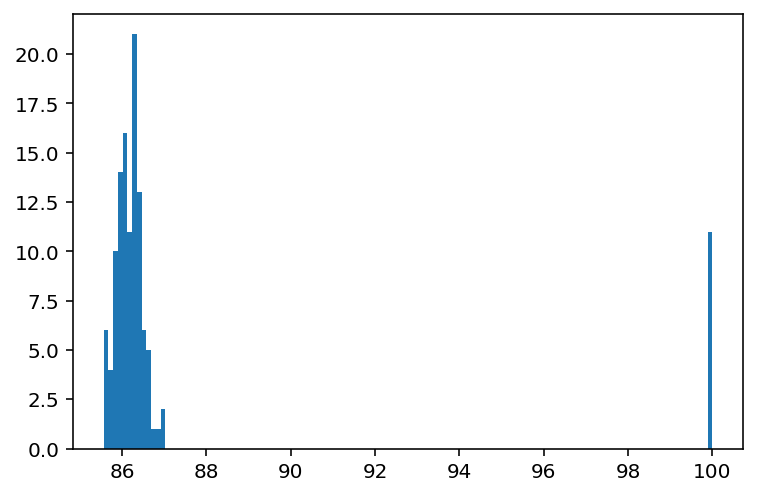

In [52]:
hist( simulated['ANI'], 128 )

In [13]:
genes = pandas.read_csv( 'data/lingjie/checkv_putput/tmp/gene_features.tsv', sep='\t' )

blast_cols = [ 'queryId', 'subjectId', 'percIdentity', 'alnLength', 
               'mismatchCount', 'gapOpenCount', 'queryStart', 'queryEnd',
               'subjectStart', 'subjectEnd', 'eVal', 'bitScore' ]

for n,rec in enumerate( parse( 'data/lingjie/concatinated.fasta', 'fasta' )  ) :
    print( genes[ genes['contig_id'] == rec.id ] )
    

                       contig_id  gene_num   start     end  strand    gc  \
0    Schulz_GVMAG_M_3300000115_3         1       3     245      -1  26.3   
1    Schulz_GVMAG_M_3300000115_3         2     332    1039       1  31.8   
2    Schulz_GVMAG_M_3300000115_3         3    1079    1558       1  36.9   
3    Schulz_GVMAG_M_3300000115_3         4    1604    2386       1  33.0   
4    Schulz_GVMAG_M_3300000115_3         5    2429    3361       1  28.4   
..                           ...       ...     ...     ...     ...   ...   
205  Schulz_GVMAG_M_3300000115_3       206  197152  197349      -1  32.3   
206  Schulz_GVMAG_M_3300000115_3       207  197422  198774       1  35.0   
207  Schulz_GVMAG_M_3300000115_3       208  198811  199983       1  30.8   
208  Schulz_GVMAG_M_3300000115_3       209  199984  200223      -1  37.9   
209  Schulz_GVMAG_M_3300000115_3       210  200306  201316       1  36.7   

     hmm_cat  hmm_db      hmm_name        evalue  score  
0          0     NaN         

In [10]:
row

contig_id    Schulz_GVMAG_M_3300000115_3
gene_num                              12
start                              11096
end                                11548
strand                                 1
gc                                  36.0
hmm_cat                                0
hmm_db                               NaN
hmm_name                             NaN
evalue                               NaN
score                                NaN
Name: 11, dtype: object